In [1]:
import import_ipynb
from ConsistencyIndexes import *
import torch.nn.functional as Fun
import torch
from torch import optim
import matplotlib.pyplot as plt

importing Jupyter notebook from ConsistencyIndexes.ipynb
importing Jupyter notebook from Functions.ipynb


In [129]:
#Extract kernels and weights from Parameters
def Extract(Params):
    k_cod = Params['k_cod']
    k_dec = Params['k_dec']
    k_cons = Params['k_cons']
    w_time = Params['w_time'] 
    return k_cod,k_dec,k_cons,w_time

In [175]:
def create_weights(in_channels, out_channels, kernel_size):
    return torch.randn(out_channels, in_channels, kernel_size, kernel_size, requires_grad=True)

In [250]:
def Gen_Params(N):
    # Encoder
    k_cod = [create_weights(3, 16, 3), create_weights(16, 32, 3), create_weights(32, 64, 3)]     
    # Decoder
    k_dec = [create_weights(32, 64, 3), create_weights(16, 32, 3), create_weights(3, 16, 3)]
    # Kernels for Temporal Consistency
    k_cons = [[create_weights(3, 16, 3),create_weights(16, 32, 3),create_weights(32, 64, 3)]  for _ in range(2*N)]
    # Weights for temporal consistency
    w_time = [torch.rand(1, requires_grad=True) for _ in range(2*N)]
    return k_cod, k_dec, k_cons, w_time

In [377]:
def ObjFun(V,x,k_cod,k_dec,k_cons,w_time):
    N = len(w_time)
    encodes = V[:N//2]+V[N//2+1:]
    #encodes = [e.unsqueeze(0) for e in encodes]
    # Encoder
    for k in k_cod:
        x = Fun.relu(Fun.conv2d(x,k,stride=2,padding=1))
    # Temporal Encoder
    for i in range(len(encodes)):
        for k in k_cons[i]:  
            encodes[i] = Fun.relu(Fun.conv2d(encodes[i],k,stride=2,padding=1))
    for e in encodes:
        x = x + e
    # Decoder
    for k in k_dec:
        x = Fun.relu(Fun.conv_transpose2d(x,k,stride=2,padding=1,output_padding=1))
    return x

In [378]:
#Add a random inconsistency
def AddOneInc1(F):
    # Convert to NumPy Array
    F = F.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255
    # Copy of original array
    I = F.astype(np.uint8).copy()
    # Random location
    x, y = random.randint(0, 2 * I.shape[0] // 3), random.randint(0, 2 * I.shape[1] // 3)
    # Random size
    l = random.randint(5,I.shape[1]//20)
    # Random option
    Op = random.randint(0, 5)
    if Op == 0:
        I[x:x + l, y:y + l] = change_range_colors(I[x:x + l, y:y + l], (random.randint(30, 140), random.randint(30, 140), random.randint(30, 140)), (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255)))
    elif Op == 1:
        R, G, B = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
        I[x:x + l, y:y + l] = change_range_colors(I[x:x + l, y:y + l], (R, G, B), (R, G, B))
    elif Op == 2:
        Thick = random.randint(1, 10)
        l2 = random.randint(5, I.shape[1]//15)
        I = cv2.line(I, (x, y), (x + l, y + l2), (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), Thick)
    elif Op == 3:
        Thick = random.randint(1, 5)
        l2 = random.randint(5, I.shape[1]//20)
        I = cv2.line(I, (x, y), (x + l, y + l2), (0, 0, 0), Thick)  
    elif Op == 4:
        I[x:x+l,y:y+l] = I[x:x+l,y:y+l] + np.random.random_integers(-10,10,I[x:x+l,y:y+l].shape)
    else:
        kernel = np.random.rand(3,3)
        I[x:x+l,y:y+l] = cv2.filter2D(I[x:x+l,y:y+l],-1,kernel)
    # Convert back to tensor
    I_tensor = torch.tensor(I, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)/255.0
    return I_tensor

In [379]:
def train(Input, Params=None, N=1, Epochs=10, Steps=10, LR=1e-3):
    if N>len(Input[0])//2:
        print("Not enough frames for size ",N)
        return None,None,None
    # Ensure inputs are float32 and have correct shape (batch_size, channels, height, width)  
    if Params is None:
        k_cod,k_dec,k_cons,w_time = Gen_Params(N)
    else:
        k_cod,k_dec,k_cons,w_time = Extract(Params)  
    # Ensure the optimizer is handling float32 parameters
    optimizer = optim.NAdam([p for p in k_cod + k_dec + w_time], lr=LR)   
    Loss = []
    LossAll = []    
    In = [[torch.tensor(cv2.resize(i,(320,320),interpolation=cv2.INTER_AREA),
                              dtype=torch.float32).permute(2,0,1).unsqueeze(0)/255.0 for i in v] for v in Input]
    for epoch in range(Epochs):
        total_loss = 0.0
        random.shuffle(In)      
        for v in range(len(In)):
            for f in range(len(In[v])-2):
                first,current,last = f,f+len(w_time)//2,f+len(w_time)
                Inc = In[v][current].clone()
                for s in range(Steps):
                    optimizer.zero_grad()  
                    if s!=0:  
                        Inc = AddOneInc1(Inc)               
                    # Perform forward pass
                    Pred = ObjFun(In[v][first:last],Inc,k_cod,k_dec,k_cons,w_time)                
                    # Compute loss
                    loss = Fun.mse_loss(In[v][current]*255,Pred*255)                
                    # Backpropagation
                    loss.backward()
                    optimizer.step()                
                    LossAll.append(loss.item())                
                    print(f'Epoch [{epoch+1}/{Epochs}] Video [{v+1}/{len(In)}] Frame [{f+1}/{len(In[v])-2}] Step [{s+1}/{Steps}] Loss: {loss.item():.6f}', end='\r')                
                    total_loss += loss.item()                
                    # Visualization
                    cv2.imshow("Original",(In[v][current]*255).squeeze(0).permute(1, 2, 0).detach().numpy().astype(np.uint8))
                    cv2.imshow("Inconsistent",(Inc[0]*255).squeeze(0).permute(1, 2, 0).detach().numpy().astype(np.uint8))
                    cv2.imshow("Predicted", (Pred[0]*255).squeeze(0).permute(1, 2, 0).detach().numpy().astype(np.uint8))
                    cv2.waitKey(1)      
        Loss.append(total_loss / len(Input))
        print(f'Epoch [{epoch + 1}/{Epochs}], Loss: {total_loss / len(Input):.6f}')  
    cv2.destroyAllWindows() 
    return {'k_cod': k_cod, 'k_dec': k_dec, 'w_time': w_time}, Loss, LossAll

In [380]:
Consec = 5
Frames = read_first_frames("VDB",Consec)
Vids = [[Frames[j*Consec+i] for i in range(Consec)] for j in range(len(Frames)//Consec)]
len(Vids),len(Vids[0])

(28, 5)

In [381]:
cv2.destroyAllWindows()

In [382]:
Parameters = None#torch.load("paramstime1.pth")

In [383]:
Parameters,L,LA = train(Vids,Params=Parameters,N=2,Epochs=1,Steps=5,LR=1e-3)

Epoch [1/1], Loss: 226400157280250.843750p [5/5] Loss: 1504633159680.0000000


In [ ]:
torch.save(Parameters,"paramstime2.pth")
Parameters = torch.load("paramstime2.pth")

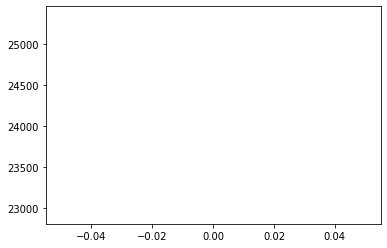

In [231]:
plt.plot(L[0:])

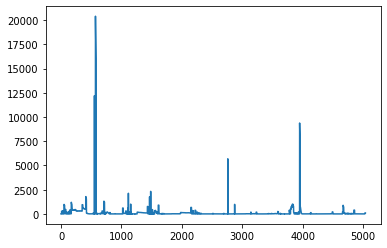

In [232]:
r = 1
plt.plot([sum(LA[i:i+r])/r for i in range(0,len(LA),r)])

In [ ]:
##Add with no inconsistencies in training
##Add detail error, MSE of full image only minimizes general pixel distribution
##Add more training examples
##Add N previous and N post current inconsistence image
##Add optical flow, frequencies or other features for temporal consistency
##Different kernel sizes
##Add Gaisian Noise
##Reconstruct image with kernel middle between encoder and decofer
##Use data with less loss value, selection
##How to combine data with less error and with more error?
##Localize area and correct error

In [252]:
def Prediction(Vid,Params):
    P = []
    V = [torch.tensor(cv2.resize(i,(320,320),interpolation=cv2.INTER_AREA),
                              dtype=torch.float32).permute(2,0,1).unsqueeze(0)/255.0 for i in Vid]
    k_cod,k_dec,w_time = Extract(Params)
    for f in range(len(V)-2):
        first,current,last = f,f+len(w_time)//2,f+len(w_time)
        Pred = ObjFun(V[first:last],V[current],k_cod,k_dec,w_time) 
        Pred = (Pred[0]*255).squeeze(0).permute(1, 2, 0).detach().numpy().astype(np.uint8)
        P.append(cv2.resize(Pred,(Vid[0].shape[1],Vid[0].shape[0]),interpolation=cv2.INTER_AREA))
    return P

In [253]:
cap = open_vid("AI Gen/movie(1).mp4")
Video = get_frames(cap)

In [254]:
PVid = Prediction(Video,Parameters)

In [255]:
ThroughFrames(PVid)

In [374]:
A = list(range(5))
A

[0, 1, 2, 3, 4]

In [375]:
N = 5
B = A[:N//2]+A[N//2+1:]
B

[0, 1, 3, 4]